In [36]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.status()

  Activating project at `~/Documents/Carnegie-Mellon/Chatterjee Group/Programming/WignerMolecule.jl/analysis`


Status `~/Documents/Carnegie-Mellon/Chatterjee Group/Programming/WignerMolecule.jl/analysis/Project.toml`
  [13f3f980] CairoMakie v0.15.6
  [780c37f4] Carlo v0.2.5
  [a93c6f00] DataFrames v1.8.0
  [f67ccb44] HDF5 v0.17.2
  [033835bb] JLD2 v0.6.2
  [ebeed567] PeriodicArrays v0.1.0 `https://github.com/PatXue/PeriodicArrays.jl#main`
  [90137ffa] StaticArrays v1.9.15


In [37]:
using CairoMakie
using Carlo.ResultTools
using DataFrames
using HDF5
using JLD2
using LinearAlgebra
using PeriodicArrays
using StaticArrays

In [38]:
# Parse DataFrame from ResultTools into more readily useable form
cleandata(filepath::AbstractString) = select(
    DataFrame(ResultTools.dataframe(filepath)),
    [:init_type, :T, :Lx, :Ly, :Mag, :Energy, :ηz, :ηxy]
)

cleandata (generic function with 1 method)

In [39]:
function generatePlot(data::AbstractDataFrame, x, y;
                      title="", xlabel="", ylabel="", line=false)
    ax = Axis(fig; title, xlabel, ylabel)

    vals = getfield.(data[:, y], :val)
    errs = getfield.(data[:, y], :err)
    scatter!(data[:, x], vals)
    if line
        lines!(data[:, x], vals)
    end
    errorbars!(data[:, x], vals, errs)

    return ax
end

function generatePlot(data::AbstractDataFrame, x, ys::Vector;
                      title="", xlabel="", ylabel="", line=false)
    ax = Axis(fig; title, xlabel, ylabel)

    for (label, y) in zip(ys, eachcol(data[:, ys]))
        vals = getfield.(y, :val)
        errs = getfield.(y, :err)
        scatter!(data[:, x], vals; label="$label")
        if line
            lines!(data[:, x], vals)
        end
        errorbars!(data[:, x], vals, errs)
    end
    axislegend()

    return ax
end

function generatePlot(data::GroupedDataFrame, x, y;
                      title, xlabel, ylabel, line=false)
    ax = Axis(fig; title, xlabel, ylabel)

    for key in keys(data)
        group = data[key]
        vals = getfield.(group[:, y], :val)
        errs = getfield.(group[:, y], :err)
        scatter!(group[:, x], vals, label="$(NamedTuple(key))")
        if line
            lines!(group[:, x], vals)
        end
        errorbars!(group[:, x], vals, errs)
    end

    axislegend()

    return ax
end

generatePlot (generic function with 3 methods)

In [ ]:
function generate_spins(task_no::Int, jobname)
    fig = Figure(size=(800, 400))

    task_str = lpad(task_no, 4, "0")
    h5open("../jobs/$jobname.data/task$task_str/run0001.dump.h5") do file
        spins = map(
            t -> [t[:data][1], t[:data][2], t[:data][3]],
            read(file, "simulation/spins")
        )
        spin_xs = map(v -> v[1], spins)
        spin_ys = map(v -> v[2], spins)
        spin_zs = map(v -> v[3], spins)
        Lx, Ly = size(spins)
        fig[1,1] = Axis(fig; title="Spins", backgroundcolor="black")
        strength = vec(spin_zs)
        arrows2d!(1:Lx, 1:Ly, spin_xs, spin_ys, lengthscale=0.5, align=:center, color=strength,
                  colorrange=(-1, 1))

        ηs = map(
            t -> [t[:data][1], t[:data][2], t[:data][3]],
            read(file, "simulation/etas")
        )
        η_xs = getindex.(ηs, 1)
        η_ys = getindex.(ηs, 2)
        η_zs = getindex.(ηs, 3)
        Lx, Ly = size(ηs)
        fig[1,2] = Axis(fig; title="ηs", backgroundcolor="black")
        strength = vec(η_zs)
        arrows2d!(1:Lx, 1:Ly, η_xs, η_ys, lengthscale=0.5, align=:center, color=strength,
                  colorrange=(-1, 1))
    end

    return fig
end

generate_spins (generic function with 1 method)

In [ ]:
function generate_mctime_plot(jobname, task_no::Int, observable::Symbol, fig=Figure(size=(800, 400)),
                              fig_pos=(1, 1))
    ax = fig[fig_pos...] = Axis(
        fig,
        title="$observable vs. Bin #",
        xlabel="Bin #",
        ylabel="$observable",
        xminorticksvisible=true
    )

    task_str = lpad(task_no, 4, "0")
    h5open("../jobs/$jobname.data/task$task_str/run0001.meas.h5") do file
        observables = file["observables"]

        samples = read(observables, "$observable/samples")
        n = length(samples)
        init = 1
        lines!(ax, collect(1:n), samples[1:n])
    end

    return fig
end

generate_mctime_plot (generic function with 3 methods)

## AFM-FE Phase Border

In [40]:
jobname = "afm-fe"
data = cleandata("../jobs/" * jobname * ".results.json")

Row,init_type,T,Lx,Ly,Mag,Energy,ηz,ηxy
,String,Float64,Int64,Int64,Measurem…,Measurem…,Measurem…,Measurem…
1,afm_fe,0.01,20,20,0.000438±5.5e-5,-49.9967±0.0016,-0.00053±0.0001,0.999903±1.1e-6
2,afm_fe,0.025,20,20,0.00078±4.8e-5,-49.9552±0.0042,0.00023±0.00018,0.999786±2.5e-6
3,afm_fe,0.05,20,20,0.0168±0.0029,-30.9±3.6,0.00028±0.00028,0.41±0.11
4,afm_fe,0.075,20,20,0.02602±0.0001,-19.38±0.025,-0.00023±0.00024,0.05994±0.00081
5,afm_fe,0.1,20,20,0.0214±0.0023,-25.3±2.9,-0.0002±0.00029,0.241±0.089
6,afm_fe,0.125,20,20,0.02571±0.00043,-20.02±0.62,-0.00028±0.00019,0.08±0.019
7,afm_fe,0.15,20,20,0.02619±7.6e-5,-19.342±0.024,0.00018±0.00037,0.06022±0.00087
8,afm_fe,0.175,20,20,0.026046±9.5e-5,-19.332±0.011,0.00011±0.00037,0.06004±0.00059
9,afm_fe,0.2,20,20,0.02606±0.00013,-19.326±0.021,-0.00035±0.00028,0.05943±0.00061


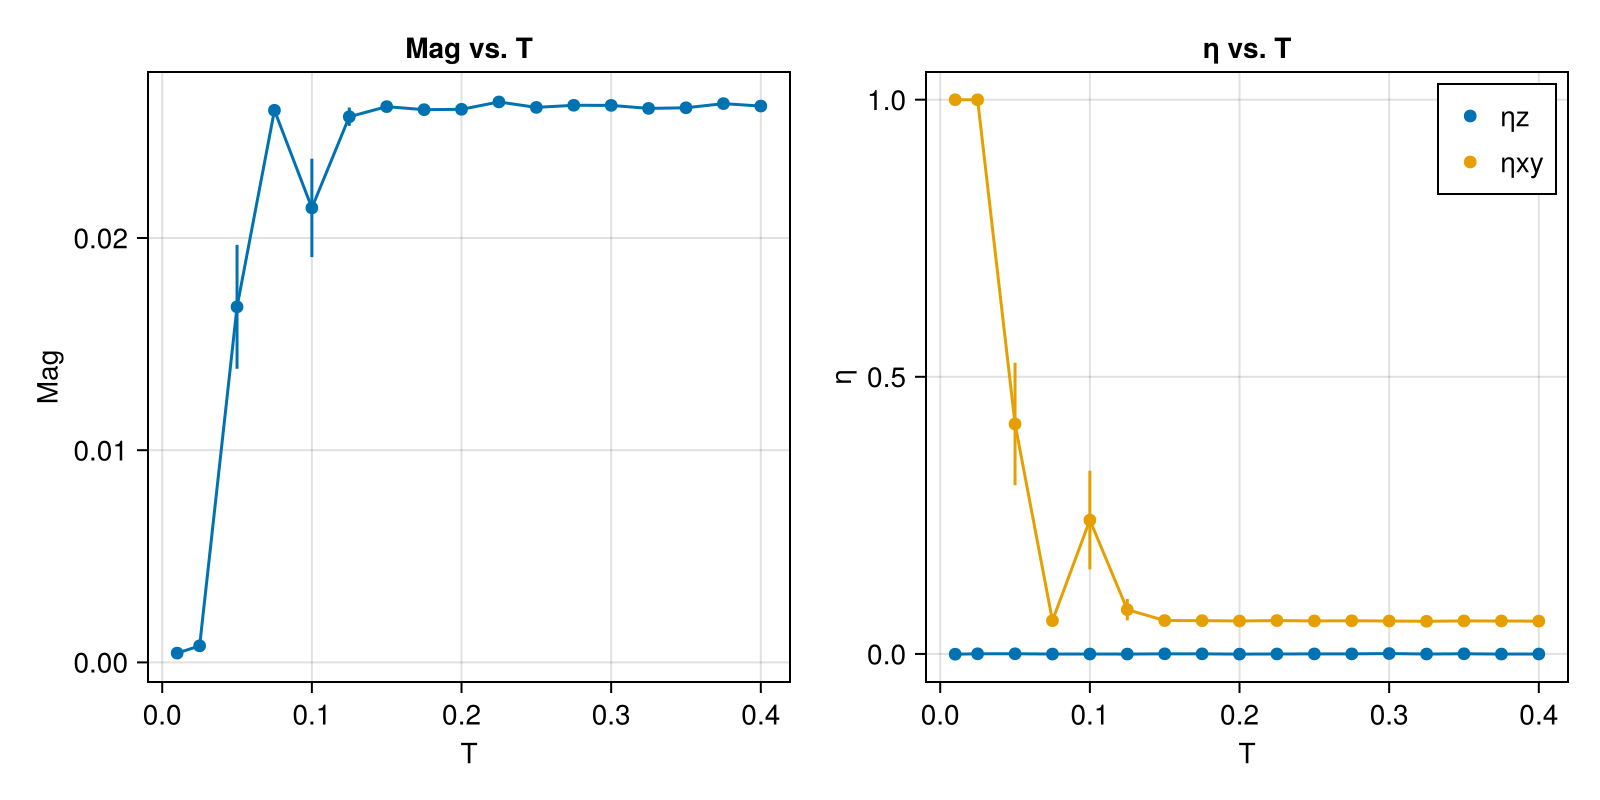

In [41]:
fig = Figure(size=(800, 400))
fig[1,1] = generatePlot(data, :T, :Mag; title="Mag vs. T", xlabel="T", ylabel="Mag", line=true)
fig[1,2] = generatePlot(data, :T, [:ηz, :ηxy]; title="η vs. T", xlabel="T", ylabel="η", line=true)
fig

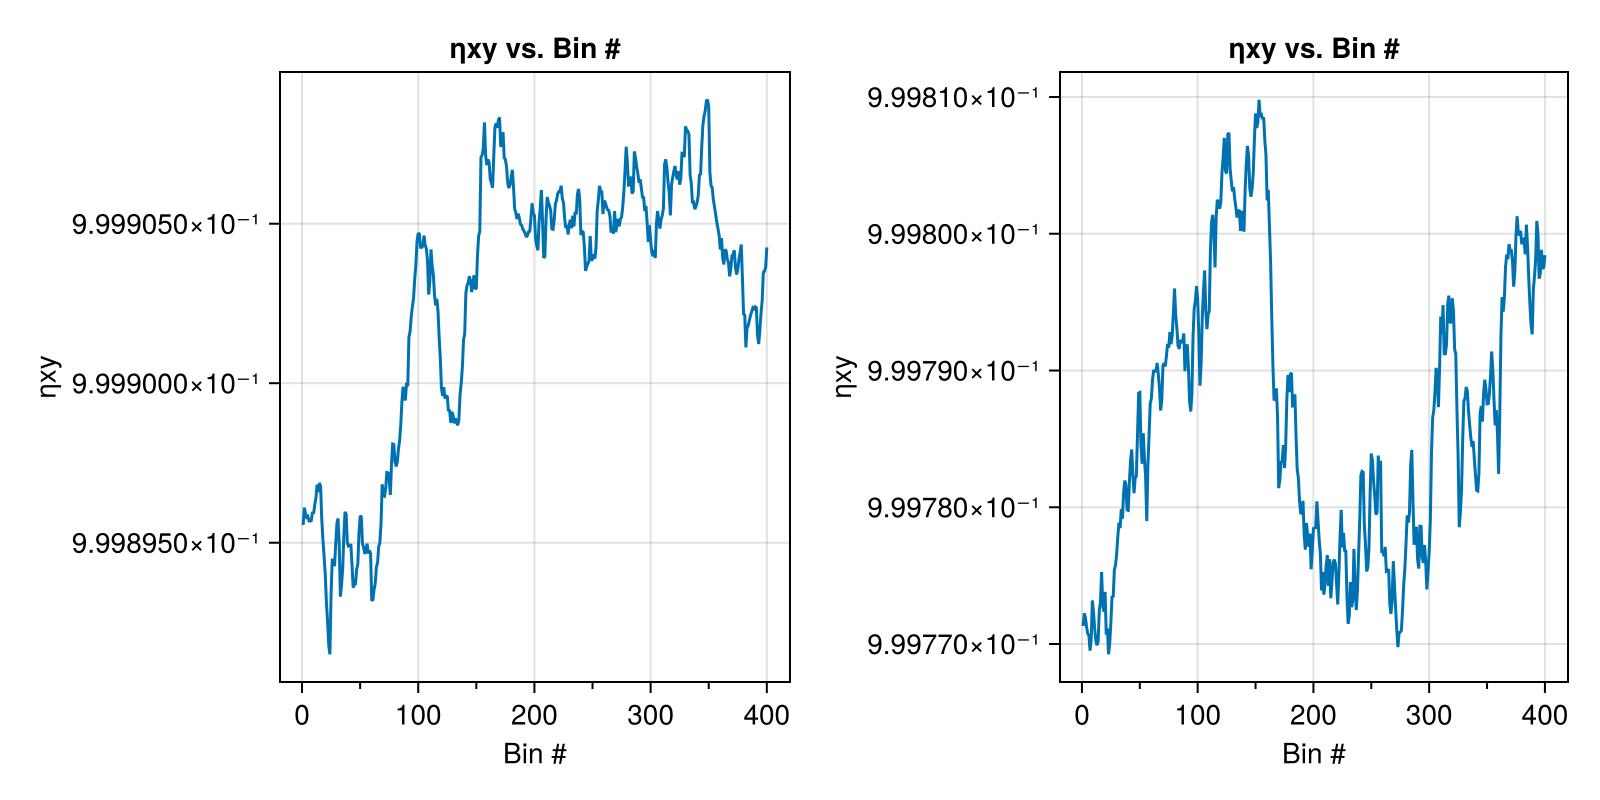

In [49]:
fig = Figure(size=(400, 800))
i = 1
fig = generate_mctime_plot(i, :ηxy)
generate_mctime_plot(i+1, :ηxy, fig, (1, 2))

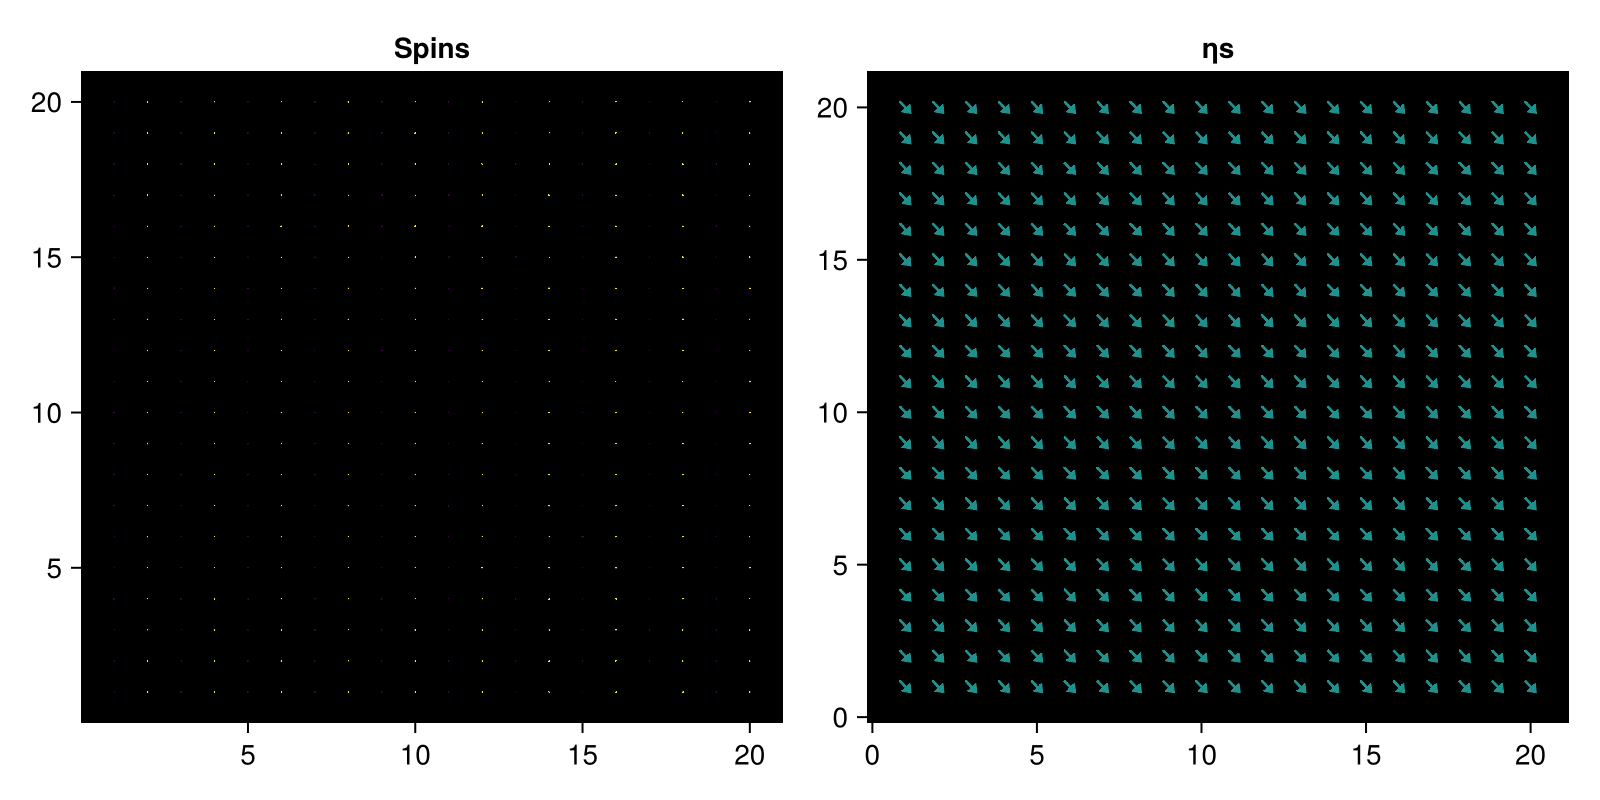

In [48]:
generate_spins(1)

## AFM-FE Phase Center

In [55]:
jobname = "afm-fe-center"
data = cleandata("../jobs/" * jobname * ".results.json")

Row,init_type,T,Lx,Ly,Mag,Energy,ηz,ηxy
,String,Float64,Int64,Int64,Measurem…,Measurem…,Measurem…,Measurem…
1,afm_fe,0.01,20,20,0.000188±1.6e-5,-92.0962±0.0018,5.0e-5±5.0e-5,0.999903±3.6e-6
2,afm_fe,0.1,20,20,0.001012±8.7e-5,-92.0111±0.0096,-0.00017±0.00021,0.999439±4.8e-6
3,afm_fe,0.2,20,20,0.02114±0.00093,-47.5±2.5,6.0e-5±0.00034,0.139±0.047
4,afm_fe,0.3,20,20,0.018±0.0022,-55.5±5.0,-0.00035±0.00035,0.299±0.098
5,afm_fe,0.4,20,20,0.02261±0.00019,-44.1±0.11,-0.00041±0.00036,0.0752±0.0014
6,afm_fe,0.5,20,20,0.0223±0.00013,-43.88±0.11,6.4e-5±0.00048,0.0752±0.0017
7,afm_fe,0.6,20,20,0.02249±0.00016,-43.73±0.12,-0.00039±0.00057,0.073±0.0016
8,afm_fe,0.7,20,20,0.0225±0.00015,-43.56±0.14,0.00022±0.00049,0.0751±0.002
9,afm_fe,0.8,20,20,0.02284±0.00012,-43.322±0.064,-0.00081±0.00043,0.0734±0.0018


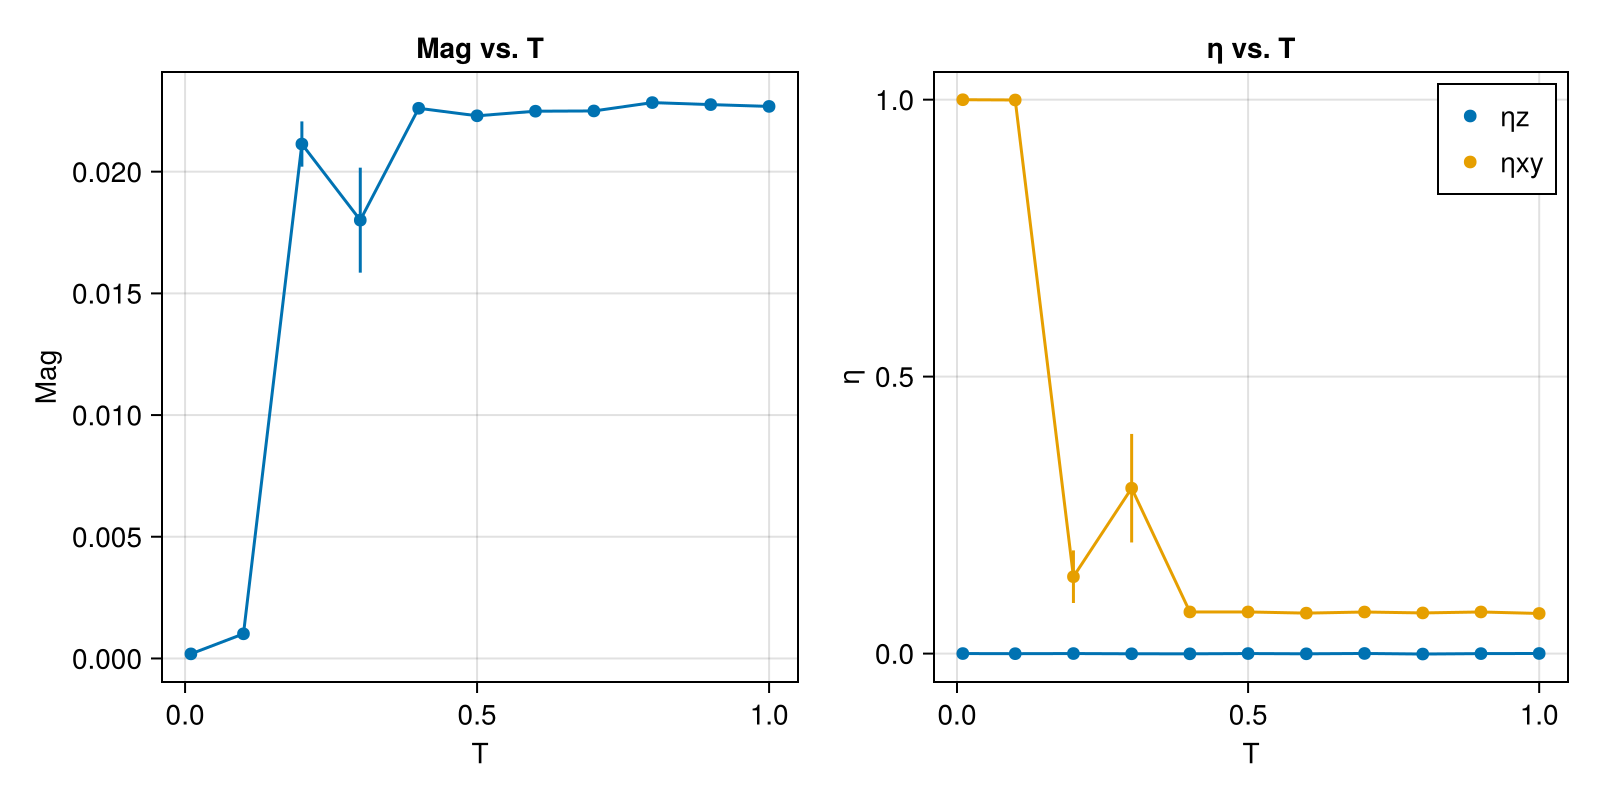

In [56]:
fig = Figure(size=(800, 400))
fig[1,1] = generatePlot(data, :T, :Mag; title="Mag vs. T", xlabel="T", ylabel="Mag", line=true)
fig[1,2] = generatePlot(data, :T, [:ηz, :ηxy]; title="η vs. T", xlabel="T", ylabel="η", line=true)
fig

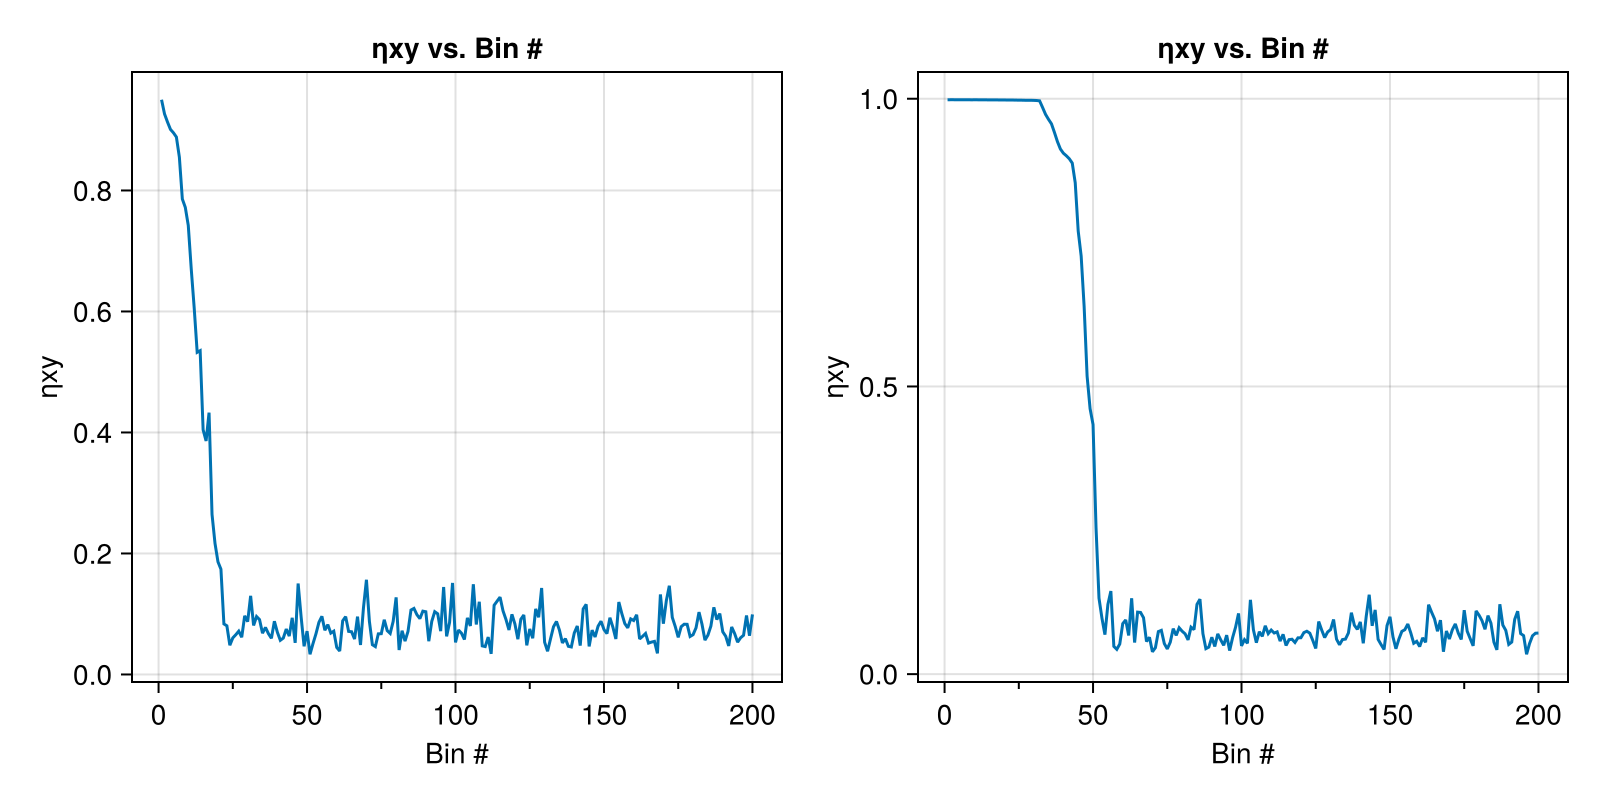

In [59]:
fig = Figure(size=(400, 800))
i = 3
fig = generate_mctime_plot(i, :ηxy)
generate_mctime_plot(i+1, :ηxy, fig, (1, 2))

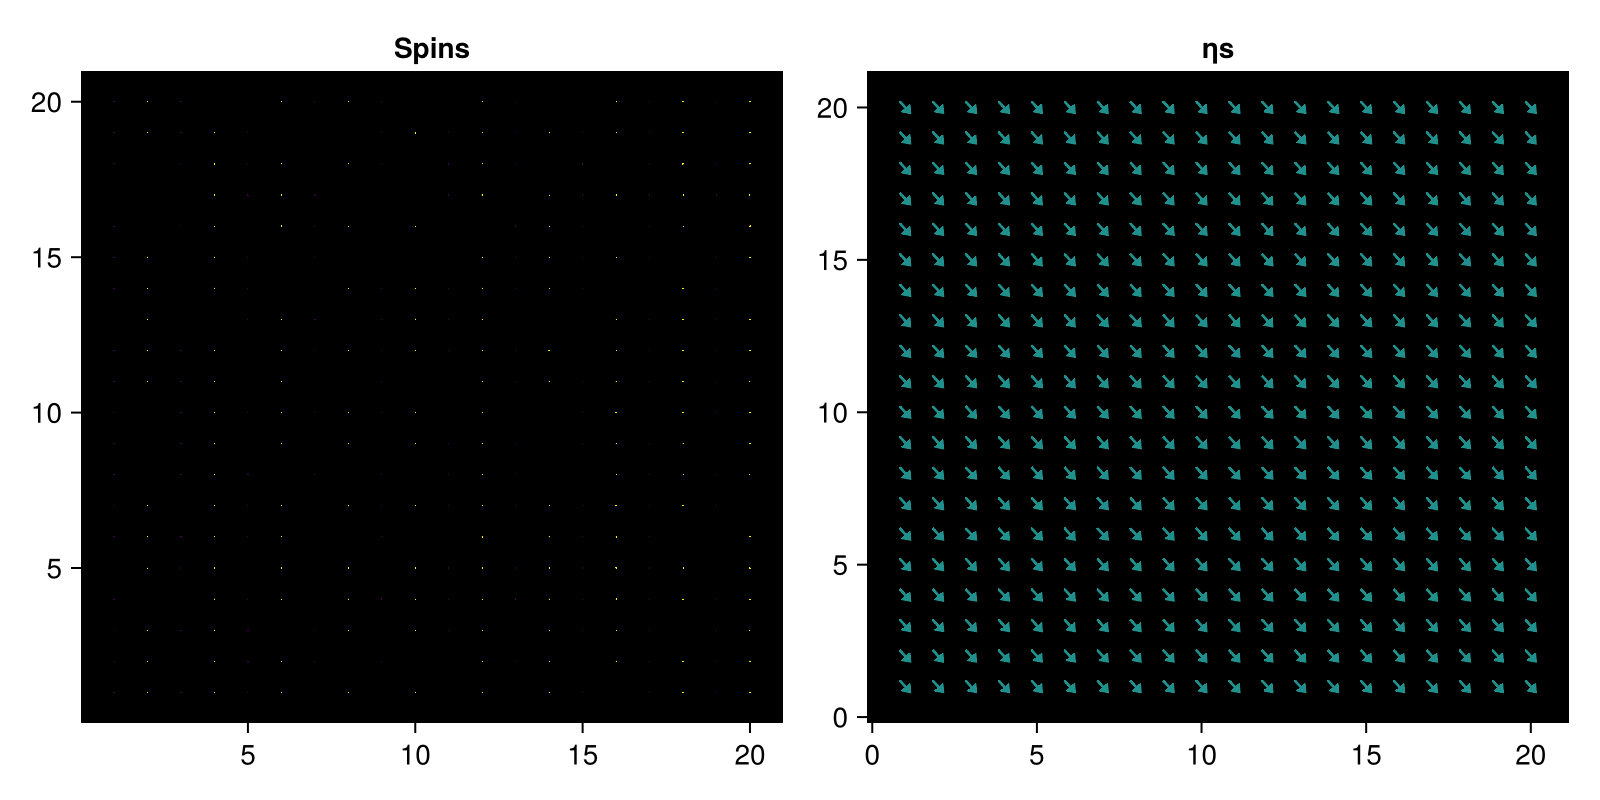

In [58]:
generate_spins(1)